### MNIST Handwritten Digit Classification

In [73]:
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist

##### Load the images and reshape the data arrays to have a single color channel.

In [74]:
# Load Dataset
(trainX,trainy),(testX,testy) = mnist.load_data()

In [75]:
trainX.shape

(60000, 28, 28)

In [76]:
print('Train: X=%s, y=%s' % (trainX.shape,trainy.shape))

Train: X=(60000, 28, 28), y=(60000,)


In [77]:
#Reshape dataset to have single channel

trainX=trainX.reshape(trainX.shape[0],28,28,1)
testX=testX.reshape(testX.shape[0],28,28,1)


In [78]:
testX.shape

(10000, 28, 28, 1)

In [79]:
#One hot encode target values
from keras.utils import to_categorical
trainy = to_categorical(trainy)
testy = to_categorical(testy)

##### load_dataset() function implements these behaviors and can be used to load the dataset

In [80]:
def load_dataset():
    #Load dataset
    (trainX,trainY),(testX,testY) = mnist.load_data()
    
    #Reshape
    trainX=trainX.reshape(trainX.shape[0],28,28,1)
    testX=testX.reshape(testX.shape[0],28,28,1)
    
    #One hot encode
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    
    return trainX,trainY,testX,testY

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


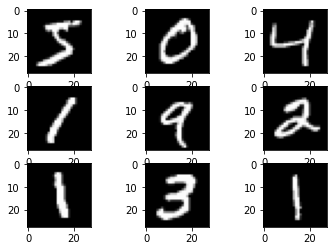

In [82]:
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

### Prepare Pixel Data

A good starting point is to normalize the pixel values of grayscale images, 
e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned 
integers to floats,then dividing the pixel values by the maximum value

In [83]:
#Convert from integer to float
train_norm = trainX.astype('float32')
test_norm = testX.astype('float32')

#normalize to range 0 to 1
train_norm = train_norm / 255.0
test_norm = test_norm / 255.0

In [84]:
#Put everything in prep_pixels() function
#Scale_pixels
def prep_pixels(train,test):
    #Convert from integer to float
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')

    #normalize to range 0 to 1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    
    return train_norm,test_norm

The model has two main aspects: the feature extraction front end comprised of convolutional and pooling layers, and the classifier backend that will make a prediction.

For the convolutional front-end, we can start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

Given that the problem is a multi-class classification task, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a softmax activation function. Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.

All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.

We will use a conservative configuration for the stochastic gradient descent optimizer with a learning rate of 0.01 and a momentum of 0.9. The categorical cross-entropy loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes.

In [85]:
from keras.models import Sequential
from keras.layers import Conv2D,Dense,MaxPooling2D,Flatten
from keras.optimizers import Adam, SGD

### Define CNN Model

In [86]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32,(3,3),activation='relu',kernel_initializer='he_uniform',input_shape=(28,28,1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(100,activation='relu',kernel_initializer='he_uniform'))
    model.add(Dense(10,activation='softmax'))
    
    #Compile model
    opt = SGD(learning_rate=0.01,momentum=0.9)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

The model will be evaluated using five-fold cross-validation. The value of k=5 was chosen to provide a baseline for both repeated evaluation and to not be so large as to require a long running time. Each test set will be 20% of the training dataset, or about 12,000 examples, close to the size of the actual test set for this problem.

The training dataset is shuffled prior to being split, and the sample shuffling is performed each time, so that any model we evaluate will have the same train and test datasets in each fold, providing an apples-to-apples comparison between models.

We will train the baseline model for a modest 10 training epochs with a default batch size of 32 examples. The test set for each fold will be used to evaluate the model both during each epoch of the training run, so that we can later create learning curves, and at the end of the run, so that we can estimate the performance of the model. As such, we will keep track of the resulting history from each run, as well as the classification accuracy of the fold.

The evaluate_model() function below implements these behaviors, taking the training dataset as arguments and returning a list of accuracy scores and training histories that can be later summarized.

In [45]:
from sklearn.model_selection import KFold

### Evaluate Model

In [48]:
#Evaluate a model using K-fold cross validation
def model_evaluate(dataX,dataY,n_fold=5):
    scores,histories = list(),list()
    
    #Prepare cross validation
    kfold = KFold(n_splits=n_fold,shuffle=True,random_state=1)
    
    #enumarate splits
    for train_ix,test_ix in kfold.split(dataX):
        #define model
        model = define_model()
        
        #select rows for train and test
        trainX,trainY,testX,testY = dataX[train_ix],dataY[train_ix],dataX[test_ix],dataY[test_ix]
        
        #fit model
        history = model.fit(trainX,trainY,epochs=10,batch_size=32,validation_data=(testX,testY),verbose=0)
        
        #evaluate model
        _,acc = model.evaluate(testX,testY,verbose=0)
        print('> %.3f',(acc*100.0))
        
        #store scores
        scores.append(acc)
        histories.append(history)
        
        return scores,histories 

Once the model has been evaluated, we can present the results.

There are two key aspects to present: the diagnostics of the learning behavior of the model during training and the estimation of the model performance. These can be implemented using separate functions.

First, the diagnostics involve creating a line plot showing model performance on the train and test set during each fold of the k-fold cross-validation. These plots are valuable for getting an idea of whether a model is overfitting, underfitting, or has a good fit for the dataset.

We will create a single figure with two subplots, one for loss and one for accuracy. Blue lines will indicate model performance on the training dataset and orange lines will indicate performance on the hold out test dataset. The summarize_diagnostics() function below creates and shows this plot given the collected training histories.

In [50]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
plt.show()

Next, the classification accuracy scores collected during each fold can be summarized by calculating the mean and standard deviation. This provides an estimate of the average expected performance of the model trained on this dataset, with an estimate of the average variance in the mean. We will also summarize the distribution of scores by creating and showing a box and whisker plot.

The summarize_performance() function below implements this for a given list of scores collected during model evaluation.


In [51]:
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()


In [62]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = model_evaluate(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

> %.3f 98.63333106040955
Accuracy: mean=98.633 std=0.000, n=1


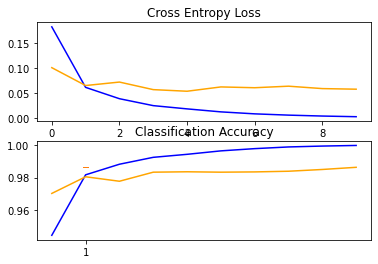

In [67]:
run_test_harness()

##### Complete Code

> 98.442
> 98.658
> 98.725
> 98.850
> 98.542


C:\Users\lakshmsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\lakshmsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


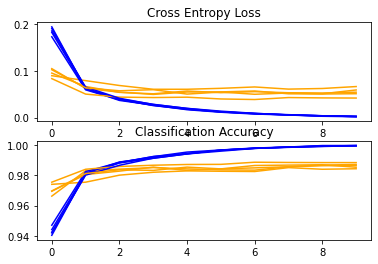

Accuracy: mean=98.643 std=0.142, n=5


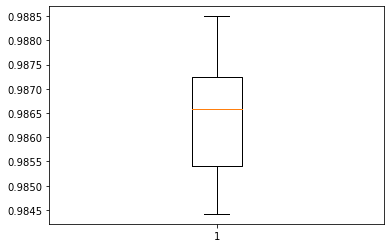

In [69]:
# baseline cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

# entry point, run the test harness
run_test_harness()

### Improvement to Learning

There are many aspects of the learning algorithm that can be explored for improvement.

Perhaps the point of biggest leverage is the learning rate, such as evaluating the impact that smaller or larger values of the learning rate may have, as well as schedules that change the learning rate during training.

Another approach that can rapidly accelerate the learning of a model and can result in large performance improvements is batch normalization. We will evaluate the effect that batch normalization has on our baseline model.

Batch normalization can be used after convolutional and fully connected layers. It has the effect of changing the distribution of the output of the layer, specifically by standardizing the outputs. This has the effect of stabilizing and accelerating the learning process.

We can update the model definition to use batch normalization after the activation function for the convolutional and dense layers of our baseline model. The updated version of define_model() function with batch normalization is listed below.

In [70]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

### CNN model with batch normalization for mnist

> 98.600
> 98.575
> 98.592
> 98.800
> 98.708


C:\Users\lakshmsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:79: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\lakshmsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


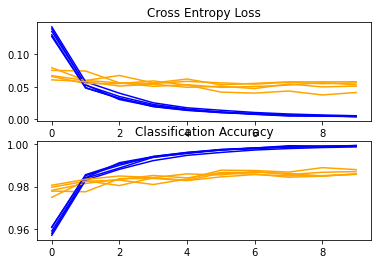

Accuracy: mean=98.655 std=0.086, n=5


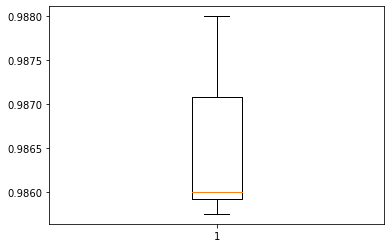

In [71]:
# cnn model with batch normalization for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import BatchNormalization

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()

# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)

# entry point, run the test harness
run_test_harness()

### Increase in Model Depth

There are many ways to change the model configuration in order to explore improvements over the baseline model.

Two common approaches involve changing the capacity of the feature extraction part of the model or changing the capacity or function of the classifier part of the model. Perhaps the point of biggest influence is a change to the feature extractor.

We can increase the depth of the feature extractor part of the model, following a VGG-like pattern of adding more convolutional and pooling layers with the same sized filter, while increasing the number of filters. In this case, we will add a double convolutional layer with 64 filters each, followed by another max pooling layer.

In [87]:
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

> 98.858
> 98.892
> 99.042
> 99.167
> 99.158


C:\Users\lakshmsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:79: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\lakshmsu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


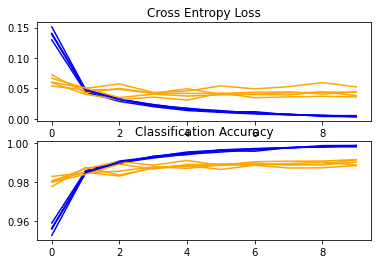

Accuracy: mean=99.023 std=0.129, n=5


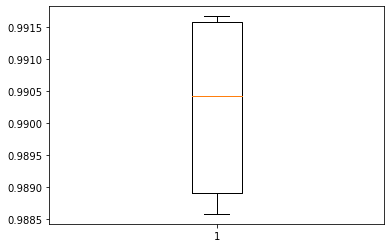

In [88]:
# deeper cnn model for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
 
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm
 
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
 
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = define_model()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# box and whisker plots of results
	pyplot.boxplot(scores)
	pyplot.show()
 
# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# evaluate model
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
 
# entry point, run the test harness
run_test_harness()

### Finalize the Model and Make Predictions

The process of model improvement may continue for as long as we have ideas and the time and resources to test them out.

At some point, a final model configuration must be chosen and adopted. In this case, we will choose the deeper model as our final model.

First, we will finalize our model, but fitting a model on the entire training dataset and saving the model to file for later use. We will then load the model and evaluate its performance on the hold out test dataset to get an idea of how well the chosen model actually performs in practice. Finally, we will use the saved model to make a prediction on a single image.

### Save Final Model

A final model is typically fit on all available data, such as the combination of all train and test dataset.

In this tutorial, we are intentionally holding back a test dataset so that we can estimate the performance of the final model, which can be a good idea in practice. As such, we will fit our model on the training dataset only.

In [89]:
# fit model
#model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
# save model
#model.save('final_model.h5')

NameError: name 'model' is not defined

In [90]:
import h5py

In [91]:
h5py.run_tests()

0

### Save the final model to file

In [92]:
# save the final model to file
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# fit model
	model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)
	# save model
	model.save('final_model.h5')

# entry point, run the test harness
run_test_harness()

### Evaluate Final Model

We can now load the final model and evaluate it on the hold out test dataset.

This is something we might do if we were interested in presenting the performance of the chosen model to project stakeholders.

The model can be loaded via the load_model() function.

In [93]:
# evaluate the deep model on the test dataset
from keras.datasets import mnist
from keras.models import load_model
from keras.utils import to_categorical

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# load model
	model = load_model('final_model.h5')
	# evaluate model on test dataset
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))

# entry point, run the test harness
run_test_harness()

> 99.090


### Make Prediction

We can use our saved model to make a prediction on new images.

The model assumes that new images are grayscale, that they have been aligned so that one image contains one centered handwritten digit, and that the size of the image is square with the size 28×28 pixels.

We will pretend this is an entirely new and unseen image, prepared in the required way, and see how we might use our saved model to predict the integer that the image represents (e.g. we expect “7“).

First, we can load the image, force it to be in grayscale format, and force the size to be 28×28 pixels. The loaded image can then be resized to have a single channel and represent a single sample in a dataset. The load_image() function implements this and will return the loaded image ready for classification.

Importantly, the pixel values are prepared in the same way as the pixel values were prepared for the training dataset when fitting the final model, in this case, normalized.

In [94]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, grayscale=True, target_size=(28, 28))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 28, 28, 1)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

# load an image and predict the class
def run_example():
	# load the image
	img = load_image('sample_image.png')
	# load model
	model = load_model('final_model.h5')
	# predict the class
	digit = model.predict_classes(img)
	print(digit[0])

# entry point, run the example
run_example()

C:\Users\lakshmsu\AppData\Roaming\Python\Python37\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


7
